## Trigger Word Detection

In this work we will see how to use works a trigger word detection (is the technology that allows devices like Amazon Alexa, Google Home to wake up upon hearing a certain word) with Keras implementation. Our input will be the word "Italy". 

In [0]:
!pip3 install pydub
!pip3 install h5py
!pip3 install scipy
!pip3 install matplotlib

In [0]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

# 1 - Data synthesis: Creating a speech dataset 

The first step is to create a dataset for our trigger word. We will use audio_clip with a mix of positive words ("italy") and negative words (random words other than italy) on different background sounds.

## 1.1 - Listening to the data   

Like i said we will use audio files to synthesize a dataset to train the model. 

The "italy" directory contains positive examples of people saying the word "italy"(variuos nationality and accents). 

The "negatives" directory contains negative examples of people saying random words other than "italy". There is one word per audio recording. 

The "backgrounds" directory contains 10 second clips of background noise in different environments.

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
IPython.display.Audio("gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/raw_data/italy/1.wav")

In [0]:
IPython.display.Audio("gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/raw_data/negatives/4.wav")

In [0]:
IPython.display.Audio("gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/raw_data/backgrounds/1.wav")

Output hidden; open in https://colab.research.google.com to view.

## 1.2 - From audio recordings to spectrograms

We will use audio sampled at 44100 Hz. This means the microphone gives us 44100 numbers per second. Thus, a 10 second audio clip is represented by 441000 numbers (= $10 \times 44100$). 

After we will compute a spectogram of the audio. The spectogram tells us how much different frequencies are in an audio clip at a moment in time and all the information that we will use to structure the next step.



In [0]:
IPython.display.Audio("gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/example_train.wav")

Output hidden; open in https://colab.research.google.com to view.

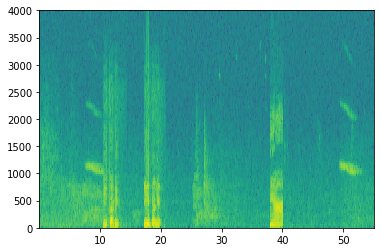

In [0]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
from pydub import AudioSegment

def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

x = graph_spectrogram("gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/example_train.wav")    

In [0]:
_, data = wavfile.read("gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/example_train.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)


Now, you can define:

In [0]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

Note that even with 10 seconds being our default training example length, 10 seconds of time can be discretized to different numbers of value. You've seen 441000 (raw audio) and 5511 (spectrogram). In the former case, each step represents $10/441000 \approx 0.000023$ seconds. In the second case, each step represents $10/5511 \approx 0.0018$ seconds. 

For the 10sec of audio, the key values  are:

- $441000$ (raw audio)
- $5511 = T_x$ (spectrogram output, and dimension of input to the neural network). 
- $10000$ (used by the `pydub` module to synthesize audio) 
- $1375 = T_y$ (the number of steps in the output of the GRU you'll build). 

Consider the $T_y = 1375$ number . This means that for the output of the model, we discretize the 10s into 1375 time-intervals (each one of length $10/1375 \approx 0.0072$s) and try to predict for each of these intervals whether someone recently finished saying "italy." 




In [0]:
Ty = 1375 # The number of time steps in the output of our model

## 1.3 - Generating a single training example

In this section we will see how to synthesize our training data using the audio clips of italy, negatives, and backgrounds. 

For single training example, we will use:

- A random 10 second background audio clip
- Randomly insert 0-3 audio clips of "italy" into this 10sec clip
- Randomly insert 0-2 audio clips of negative words into this 10sec clip

For the audio manipulation will use the pydub package. Pydub converts raw audio files into lists of Pydub data structures. Pydub uses 1ms as the discretization interval (1ms is 1 millisecond = 1/1000 seconds) which is why a 10sec clip is always represented using 10,000 steps. 

In [0]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio()

print("background len: " + str(len(backgrounds[0])))    
print("activate[0] len: " + str(len(activates[0])))     
print("activate[1] len: " + str(len(activates[2])))     

background len: 10000
activate[0] len: 888
activate[1] len: 984


**Overlaying positive/negative words on the background**:

Given a 10sec background clip and a short audio clip (positive or negative word), you need to be able to "add" or "insert" the word's short audio clip onto the background. To ensure audio segments inserted onto the background do not overlap, you will keep track of the times of previously inserted audio clips. You will be inserting multiple clips of positive/negative words onto the background, and you don't want to insert an "activate" or a random word somewhere that overlaps with another clip you had previously added. 

For clarity, when you insert a 1sec "activate" onto a 10sec clip of cafe noise, you end up with a 10sec clip that sounds like someone sayng "activate" in a cafe, with "activate" superimposed on the background cafe noise. You do *not* end up with an 11 sec clip. You'll see later how pydub allows you to do this. 

**Creating the labels at the same time you overlay**:

Recall also that the labels $y^{\langle t \rangle}$ represent whether or not someone has just finished saying "italy." Given a background clip, we can initialize $y^{\langle t \rangle}=0$ for all $t$, since the clip doesn't contain any Hotwords. 

When you insert or overlay an "italy" clip, you will also update labels for $y^{\langle t \rangle}$, so that 50 steps of the output now have target label 1. You will train a GRU to detect when someone has *finished* saying "italy". For example, suppose the synthesized "italy" clip ends at the 5sec mark in the 10sec audio---exactly halfway into the clip. Recall that $T_y = 1375$, so timestep $687 = $ `int(1375*0.5)` corresponds to the moment at 5sec into the audio. So, you will set $y^{\langle 688 \rangle} = 1$. Further, you would quite satisfied if the GRU detects "italy" anywhere within a short time-internal after this moment, so we actually set 50 consecutive values of the label $y^{\langle t \rangle}$ to 1. Specifically, we have $y^{\langle 688 \rangle} = y^{\langle 689 \rangle} = \cdots = y^{\langle 737 \rangle} = 1$.  

This is another reason for synthesizing the training data: It's relatively straightforward to generate these labels $y^{\langle t \rangle}$ as described above. In contrast, if you have 10sec of audio recorded on a microphone, it's quite time consuming for a person to listen to it and mark manually exactly when "italy" finished. 


In [0]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [0]:
# GRADED FUNCTION: is_overlapping

def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    ### START CODE HERE ### (≈ 4 line)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
    ### END CODE HERE ###

    return overlap

In [0]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


Now we will insert the background in the audio clip with the function below.

In [0]:
# GRADED FUNCTION: insert_audio_clip

def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Add the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
    ### END CODE HERE ###
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [0]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(backgrounds[0], activates[1], [(3790, 4400)])
audio_clip.export("test.wav", format="wav")
print("Segment Time: ", segment_time)

Segment Time:  (2915, 3634)


In [0]:
IPython.display.Audio("gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/test.wav")

Output hidden; open in https://colab.research.google.com to view.

Finally, implement code to update the labels $y^{\langle t \rangle}$, assuming you just inserted an "italy." In the code below, `y` is a `(1,1375)` dimensional vector, since $T_y = 1375$. 

If the "italy" ended at time step $t$, then set $y^{\langle t+1 \rangle} = 1$ as well as for up to 49 additional consecutive values. However, make sure you don't run off the end of the array and try to update `y[0][1375]`, since the valid indices are `y[0][0]` through `y[0][1374]` because $T_y = 1375$. So if "italy" ends at step 1370, you would get only `y[0][1371] = y[0][1372] = y[0][1373] = y[0][1374] = 1`

In [0]:
# GRADED FUNCTION: insert_ones

def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y

sanity checks: 0.0 1.0 0.0


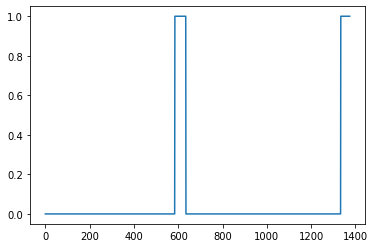

In [0]:
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

In [0]:
# GRADED FUNCTION: create_training_example

def create_training_example(background, activates, negatives):
    """
    Creates a training example with a given background, italy, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    italy -- a list of audio segments of the word "italy"
    negatives -- a list of audio segments of random words that are not "italy"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Set the random seed
    np.random.seed(18)
    
    # Make background quieter
    background = background - 20

    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###
    
    # Select 0-3 random "italy" audio clips from the entire list of "italy" recordings
    number_of_activates = np.random.randint(0, 3)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    ### START CODE HERE ### (≈ 3 lines)
    # Step 3: Loop over randomly selected "italy" clips and insert in background
    for random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end_ms=segment_end)
    ### END CODE HERE ###

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 2)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    ### START CODE HERE ### (≈ 2 lines)
    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    ### END CODE HERE ###
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
    print("File (train.wav) was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y

File (train.wav) was saved in your directory.


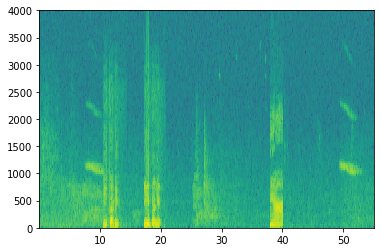

In [0]:
x, y = create_training_example(backgrounds[1], activates, negatives)

In [0]:
y.shape

(1, 1375)

In [0]:
IPython.display.Audio("gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/train.wav")

Output hidden; open in https://colab.research.google.com to view.

Finally, you can plot the associated labels for the generated training example.

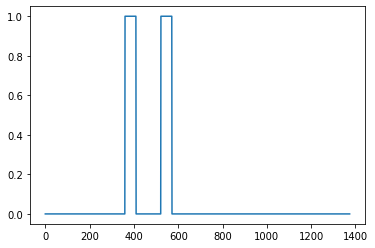

In [0]:
plt.plot(y[0])

## 1.4 - Full training set

You've now implemented the code needed to generate a single training example. We used this process to generate a large training set.

In [0]:
# Load preprocessed training examples
X = np.load("gdrive/My Drive/Final_Work/Data/XY_train/X.npy")
Y = np.load("gdrive/My Drive/Final_Work/Data/XY_train/Y.npy")

In [0]:
Y.shape

(26, 1375, 1)

## 1.5 - Development set

To test our model, we recorded a development set of 25 examples. While our training data is synthesized, we want to create a development set using the same distribution as the real inputs. 


In [0]:
# Load preprocessed dev set examples
X_dev = np.load("gdrive/My Drive/Final_Work/Data/XY_dev/X_dev.npy")
Y_dev = np.load("gdrive/My Drive/Final_Work/Data/XY_dev/Y_dev.npy")

In [0]:
Y_dev.shape

(25, 1375, 1)

# 2 - Model

Now that you've built a dataset, lets write and train a trigger word detection model! 

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

Using TensorFlow backend.


## 2.1 - Build the model

Here is the architecture we will use. 

uni-directional RNN build with 4 layers:
 - 1D convolutional layer
 - two GRU layers
 - dense layer

In [0]:
# GRADED FUNCTION: model

def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(196, kernel_size=15, strides=4)(X_input)                                 # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X) # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X)   # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                  # Batch normalization
    X = Dropout(0.8)(X)                                  # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [0]:
model = model(input_shape = (Tx, n_freq))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Let's print the model summary to keep track of the shapes.

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5511, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1375, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1375, 196)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1375, 128)         124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1375, 128)         0   

## 2.2 - Fit the model

In [0]:
model = load_model('gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/models/tr_model.h5')









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


You can train the model further, using the Adam optimizer and binary cross entropy loss, as follows. This will run quickly because we are training just for one epoch and with a small training set of 26 examples. 

In [0]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [0]:
model.fit(X, Y, batch_size = 5, epochs=1)

Epoch 1/1
26/26 [==============================] - 18s 711ms/step - loss: 0.0726 - acc: 0.9805


## 2.3 - Test the model

Finally, let's see how your model performs on the dev set.

In [0]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

25/25 [==============================] - 2s 65ms/step
Dev set accuracy =  0.9312872886657715


# 3 - Making Predictions

Now that you have built a working model for trigger word detection, let's use it to make predictions. This code snippet runs audio (saved in a wav file) through the network. 

<!--
can use your model to make predictions on new audio clips.

You will first need to compute the predictions for an input audio clip.

**Exercise**: Implement predict_activates(). You will need to do the following:

1. Compute the spectrogram for the audio file
2. Use `np.swap` and `np.expand_dims` to reshape your input to size (1, Tx, n_freqs)
5. Use forward propagation on your model to compute the prediction at each output step
!-->

In [0]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

Once you've estimated the probability of having detected the word "italy" at each output step, you can trigger a "chiming" sound to play when the probability is above a certain threshold. Further, $y^{\langle t \rangle}$ might be near 1 for many values in a row after "italy" is said, yet we want to chime only once. So we will insert a chime sound at most once every 75 output steps. This will help prevent us from inserting two chimes for a single instance of "italy". (This plays a role similar to non-max suppression from computer vision.) 


In [0]:
chime_file = "gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

## 3.3 - Test on dev examples

In [0]:
IPython.display.Audio("gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/raw_data/dev/1.wav")

Output hidden; open in https://colab.research.google.com to view.

In [0]:
IPython.display.Audio("gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/raw_data/dev/2.wav")

Output hidden; open in https://colab.research.google.com to view.

Now lets run the model on these audio clips and see if it adds a chime after "italy"!

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7747: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


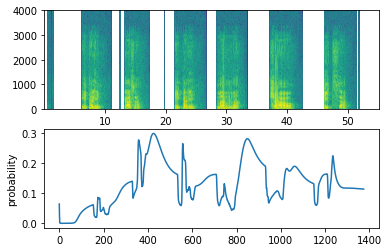

In [0]:
filename = "gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/raw_data/dev/1.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)

In [0]:
IPython.display.Audio("gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/chime_output.wav")

Output hidden; open in https://colab.research.google.com to view.

In [0]:
filename  = "gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/raw_data/dev/2.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/chime_output.wav")

Output hidden; open in https://colab.research.google.com to view.

# 4 - Try your own example

It's possible to try your own audio_clip and try to insert the chime sound after the detection of the Hotword


In [0]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

In [0]:
your_filename = "gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/raw_data/dev/3.wav"

In [0]:
preprocess_audio(your_filename)
IPython.display.Audio(your_filename) # listen to the audio you uploaded 

Finally, use the model to predict when you say "italy" in the 10 second audio clip, and trigger a chime. If beeps are not being added appropriately, try to adjust the chime_threshold.

In [0]:
chime_threshold = 0.5
prediction = detect_triggerword(your_filename)
chime_on_activate(your_filename, prediction, chime_threshold)

In [0]:
IPython.display.Audio("gdrive/My Drive/Final_Work/Keras-Trigger-Word-master/chime_output.wav")